In [1]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections
from maze_generator.maze_generator import generate_maze

Generate the maze

In [2]:
x_dim = 10
y_dim = 10
# fc_nn, conv_nn, conv_nn_2, conv_nn_3
model_type = 'conv_nn'
generate_maze(x_dim, y_dim)

Maze created and saved to 'maze_generator/maze'


**Introduce experience replay.**

In [3]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

**Networks definition.**

In [4]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, classification = False, additional_out=False):        
        # print(f"x shape before reshape: {x.shape}")
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        # print(f"x shape after reshape: {out.shape}")

        return out

In [5]:
class conv_nn(nn.Module):
    
    channels = [8, 16, 32]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(nn.Linear(size_out_conv, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, n_act))


    def forward(self, x):
        # print(f"x shape before reshape: {x.shape}")
        # print(f"in channels: {self.in_channels}")
        # print(f"row: {self.rows}")
        # print(f"cols: {self.cols}")
        # print(f"len(x): {len(x)}")
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        # print(f"size of output is {x.shape}")
        out_conv = self.conv(x).view(len(x),-1)
        out_lin = self.linear(out_conv)
        # print(f"size of output is {out_line.shape}")
        return out_lin
        
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1,self.in_channels, x, y))
        return int(np.prod(out_conv.size()))

In [6]:
class conv_nn_2(nn.Module):
    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    dropout_prob = 0.3
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(
            nn.Conv2d(self.in_channels, self.channels[0], kernel_size=self.kernels[0], stride=self.strides[0], padding=1),
            nn.BatchNorm2d(self.channels[0]),
            nn.ReLU(),
            nn.Conv2d(self.channels[0], self.channels[1], kernel_size=self.kernels[1], stride=self.strides[1], padding=1),
            nn.BatchNorm2d(self.channels[1]),
            nn.ReLU(),
            nn.Conv2d(self.channels[1], self.channels[2], kernel_size=self.kernels[2], stride=self.strides[2], padding=1),
            nn.BatchNorm2d(self.channels[2]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_prob)
        )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(
            nn.Linear(size_out_conv, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_act)
        )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x), -1)
        out_lin = self.linear(out_conv)
        return out_lin
        
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1, self.in_channels, x, y))
        return int(np.prod(out_conv.size()))


In [7]:
class conv_nn_3(nn.Module):
    channels = [32, 64, 128]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    dropout_prob = 0.3
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(
            nn.Conv2d(self.in_channels, self.channels[0], kernel_size=self.kernels[0], stride=self.strides[0], padding=1),
            nn.BatchNorm2d(self.channels[0]),
            nn.ReLU(),
            nn.Conv2d(self.channels[0], self.channels[1], kernel_size=self.kernels[1], stride=self.strides[1], padding=1),
            nn.BatchNorm2d(self.channels[1]),
            nn.ReLU(),
            nn.Conv2d(self.channels[1], self.channels[2], kernel_size=self.kernels[2], stride=self.strides[2], padding=1),
            nn.BatchNorm2d(self.channels[2]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_prob)
        )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(
            nn.Linear(size_out_conv, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_act)
        )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x), -1)
        out_lin = self.linear(out_conv)
        return out_lin
        
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1, self.in_channels, x, y))
        return int(np.prod(out_conv.size()))


In [8]:
def Qloss(batch, net, gamma=0.99, device="cuda"):
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)
    state_action_values = net(states.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    
    next_state_values = net(next_states.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]
    
    next_state_values = next_state_values.detach()
    expected_state_action_values = next_state_values * gamma + rewards
    
    return nn.MSELoss()(state_action_values, expected_state_action_values)

**Import the maze and define the environment.**

Reaching the Goal = +1 reward

Each Move = -0.05 reward (to encourage efficiency)

Revisiting a Cell = -0.2 reward (to discourage loops)

Hitting a Wall or Boundary = -1 reward (to prevent invalid moves)


In [9]:
from environment import MazeEnvironment

maze = np.load('maze_generator/maze.npy')

initial_position = [0,0]
goal = [len(maze)-1, len(maze)-1]

maze_env = MazeEnvironment(maze, initial_position, goal)

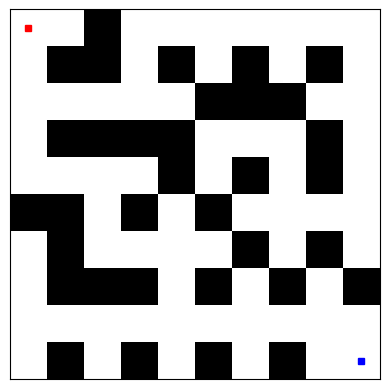

In [10]:
maze_env.draw('maze_20.pdf')

**Define the agent and the buffer for experience replay.**

In [11]:
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

In [12]:
from agent import Agent
agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
             )

In [13]:
agent.env

** Define the network.**

In [14]:
if model_type == 'fc_nn':
    net = fc_nn(maze.size, maze.size, maze.size, 4)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
elif model_type == 'conv_nn':
    net = conv_nn(x_dim, y_dim, 4)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
elif model_type == 'conv_nn_2':
    net = conv_nn_2(x_dim, y_dim, 4)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
elif model_type == 'conv_nn_3':
    net = conv_nn_3(x_dim, y_dim, 4)
    optimizer = optim.Adam(net.parameters(), lr=1e-4) 
else:
    raise ValueError(f"Unknown Model Type {model_type}")

In [15]:
device = 'cuda'
batch_size = 24
gamma = 0.9

net.to(device)

conv_nn(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

**Define the epsilon profile and plot the resetting probability.**

In [16]:
# Smaller cutoff leads to faster decay
num_epochs = 2000
cutoff = 300

min_cutoff = max(1, int(num_epochs/100))  # Minimum cutoff to avoid division by zero
max_cutoff = num_epochs - 1  # Maximum cutoff to stay within array bounds
print(f"Valid cutoff range: {min_cutoff} to {max_cutoff}")

# Calculate index safely
index = min(int(num_epochs/cutoff) * 100, num_epochs-1)  # This ensures index is within bounds
print(f"Using index: {index}")

Valid cutoff range: 20 to 1999
Using index: 600


[1.         0.99667222 0.99335551 ... 0.00128542 0.00128115 0.00127688]


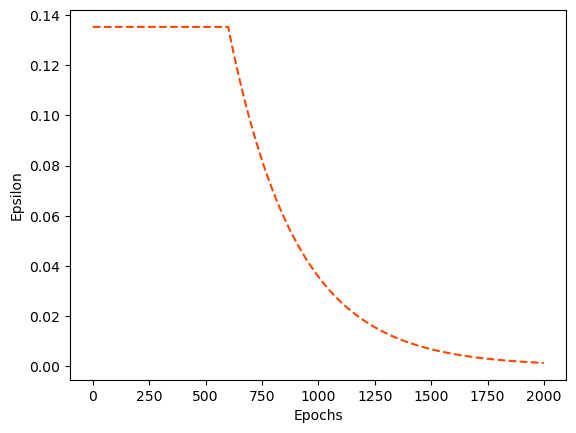

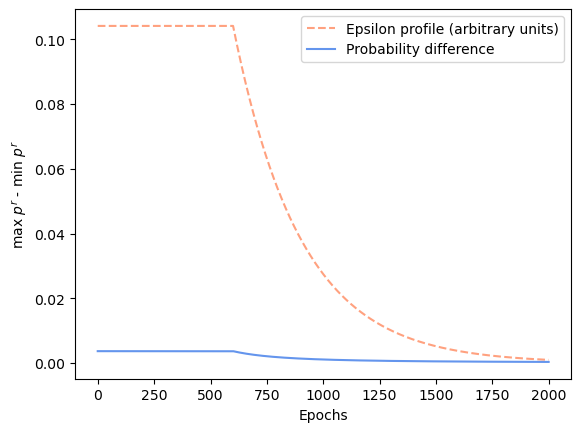

In [17]:
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
print(epsilon)
epsilon[epsilon > epsilon[index]] = epsilon[index]
# epsilon[epsilon > epsilon[int(num_epochs/cutoff) * 100 - 1]] = epsilon[int(num_epochs/cutoff) * 100 - 1]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

**Training the network.**

In [18]:
loss_log = []
best_loss = 1e5

running_loss = 0

moves_per_epoch = []
reward_per_epoch = []
for epoch in range(num_epochs):
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    agent.isgameon = True
    _ = agent.env.reset(eps)

    acc_reward = 0
    while agent.isgameon:
        acc_reward = agent.total_reward

        agent.make_a_move(net, eps)

        # prev_reward = agent.total_reward  # Store before the move
        # agent.make_a_move(net, eps)  # This updates agent.total_reward
        # reward = agent.total_reward - prev_reward  # Get reward difference
        # acc_reward += reward  # Accumulate reward over epoch
        # print(f"Total Reward: {total_reward}")
        counter += 1
        
        if len(agent.buffer) < buffer_start_size:
            continue
            
        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device = device)
        # print(f"length of batch is {len(batch)}")
        states, actions, next_states, rewards, _ = batch
        # print(f"this is the state ({len(states[0])} x {len(states[0][0])}): {states[0]}")
        # print(f"these are the actions ({len(actions)}): {actions}")
        # print(f"these are the next states ({len(next_states[0])} x {len(next_states[0][0])}): {next_states[0]}")
        # print(f"the rewards ({len(rewards)} x {len(rewards)}) are {rewards}")
        
        loss_t = Qloss(batch, net, gamma = gamma, device = device)
        loss_t.backward()
        optimizer.step()
        
        loss += loss_t.item()

    print(f"Reward Gained: {acc_reward}")
    reward_per_epoch.append(acc_reward)

    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'
    
    if epoch%1000 == 0:
        agent.plot_policy_map(net, 'sol_epoch_'+str(epoch)+'.pdf', [0.35,-0.3])
    
    loss_log.append(loss)
    
    if (epoch > 2000):
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(net.state_dict(), "best.torch")
            estop = epoch
            
    moves_per_epoch.append(counter)
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if (epoch > 2000):
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
    clear_output(wait = True)
    
print(f"Model saved as 'best.torch'")

Model saved as 'best.torch'


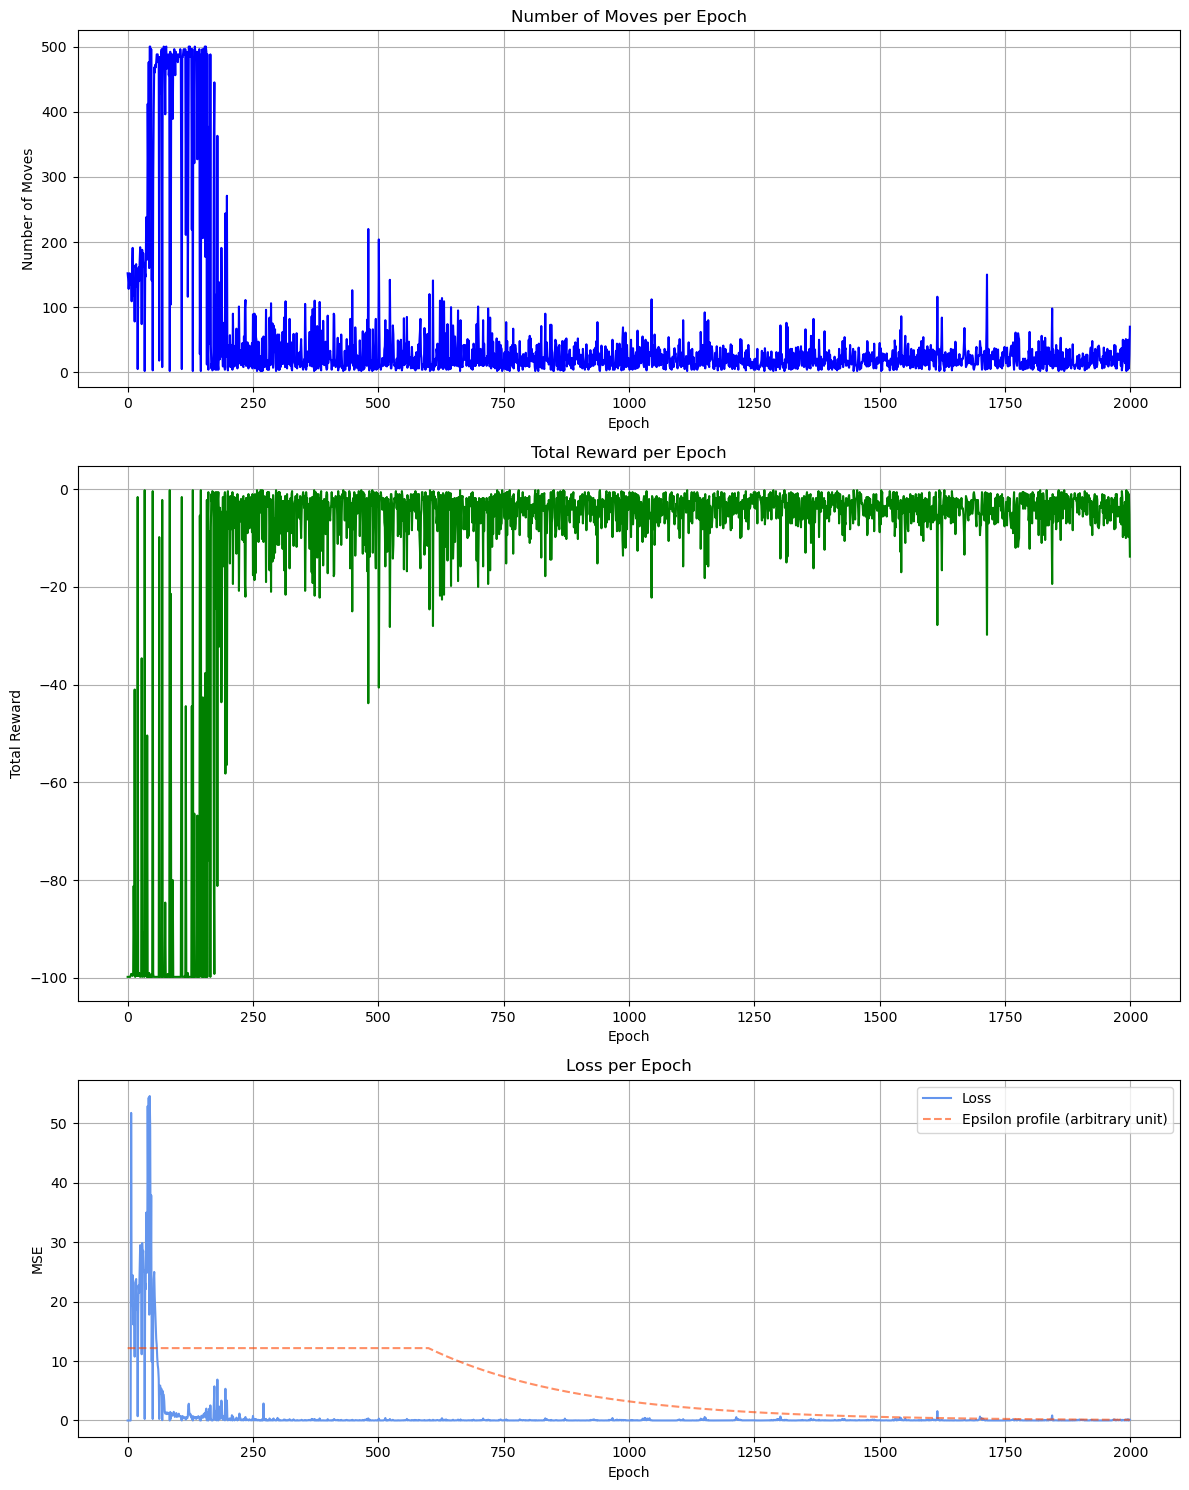

In [19]:
# Create subplots with custom height ratios
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), gridspec_kw={'height_ratios': [2, 3, 2]})

# Number of moves per epoch
axes[0].plot(moves_per_epoch, color='blue')
axes[0].set_title('Number of Moves per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Number of Moves')
axes[0].grid(True)

# Reward per epoch (now second)
axes[1].plot(reward_per_epoch, color='green')
axes[1].set_title('Total Reward per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Total Reward')
axes[1].grid(True)

# Loss per epoch with Epsilon profile (now third)
axes[2].plot(loss_log, label='Loss', color='cornflowerblue')
axes[2].plot(epsilon * 90, alpha=0.6, ls='--', label='Epsilon profile (arbitrary unit)', color='orangered')
axes[2].set_title('Loss per Epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('MSE')
axes[2].legend()
axes[2].grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'plots/{model_type}_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
torch.save(net.state_dict(), "net.torch")

Calculate average reward

In [21]:
agent.env

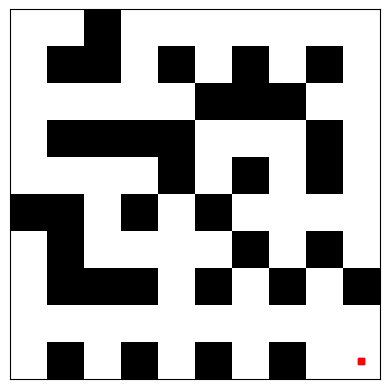

In [22]:
num_simulations = 10
for i in range(num_simulations):
    net.eval()
    agent.isgameon = True
    agent.use_softmax = False
    _ = agent.env.reset(0)
    while agent.isgameon:
        agent.make_a_move(net, 0)
        agent.env.draw('')
        clear_output(wait = True)

**Show the maze solution and the policy learnt.**

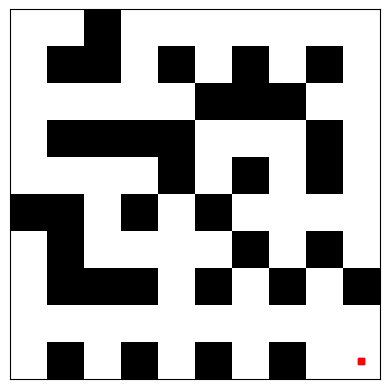

In [23]:
num_simulations = 10
for i in range(num_simulations):
    net.eval()
    agent.isgameon = True
    agent.use_softmax = False
    _ = agent.env.reset(0)
    while agent.isgameon:
        agent.make_a_move(net, 0)
        agent.env.draw('')
        clear_output(wait = True)

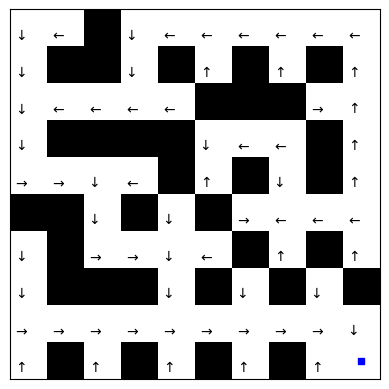

In [24]:
agent.plot_policy_map(net, 'solution.pdf', [0.35,-0.3])

In [25]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load('net.torch'))

<All keys matched successfully>

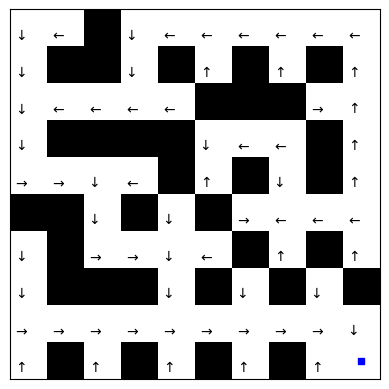

In [26]:
agent.plot_policy_map(best_net, 'solution_best.pdf', [0.35,-0.3])